In [ ]:
# Cell 1: imports and config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, precision_recall_curve, auc
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib

# Directories
os.makedirs("models", exist_ok=True)
os.makedirs("reports", exist_ok=True)
plt.rcParams.update({'figure.max_open_warning': 0})

In [3]:
# open the dataset
data = '../clean_data/cleaned_DDoS_and_begnin_traffic_dataset.csv'
df = pd.read_csv(data)

# Inspect
print("Rows, cols:", df.shape)
print("Columns:", df.columns.tolist())
# Assuming Label column exists and contains 'BENIGN' and attack names
label_col = " Label"  # change if necessary

# Convert to binary: 0 = BENIGN, 1 = ATTACK (any non-BENIGN)
df['target'] = (df[label_col] != 'BENIGN').astype(int)

# If your labels are already numeric adjust accordingly
print("Target value counts:\n", df['target'].value_counts())

# Drop original label column from features for training
X_raw = df.drop(columns=[label_col, 'target'])
y = df['target'].values

print("Feature count before selection:", X_raw.shape[1])

Rows, cols: (405401, 79)
Columns: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Coun

In [4]:
# Cell 3: Split into train/test (stratified)
RANDOM_STATE = 42
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)
print("Train shape:", X_train_raw.shape, "Test shape:", X_test_raw.shape)

Train shape: (283780, 78) Test shape: (121621, 78)


In [5]:
# Cell 4: Min-Max scaling
scaler = MinMaxScaler()
# Fit on training set and transform both
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

In [6]:
# Cell 5: Feature selection with SelectKBest (k=20)
K = 20
selector = SelectKBest(score_func=f_classif, k=K)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)

# Which features were selected?
selected_mask = selector.get_support()
selected_features = X_train_raw.columns[selected_mask].tolist()
print("Selected features (k={}):".format(K))
for f in selected_features:
    print("  ", f)

Selected features (k=20):
    Destination Port
    Fwd Packet Length Mean
   Bwd Packet Length Max
    Bwd Packet Length Min
    Bwd Packet Length Mean
    Bwd Packet Length Std
    Fwd IAT Std
   Bwd IAT Total
    Min Packet Length
    Max Packet Length
    Packet Length Mean
    Packet Length Std
    Packet Length Variance
    PSH Flag Count
    ACK Flag Count
    URG Flag Count
    Average Packet Size
    Avg Fwd Segment Size
    Avg Bwd Segment Size
    min_seg_size_forward


/home/passwd/DDoS_Detection/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [31 32 33 49 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/passwd/DDoS_Detection/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [7]:
# Cell 6: Utility functions for evaluation & saving
def evaluate_and_plot(model, X_test, y_test, model_name, save_prefix="reports/"):
    """
    Evaluate model, print classification report, plot confusion matrix & ROC.
    """
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        try:
            scores = model.decision_function(X_test)
            # scale to [0,1] via minmax for ROC plotting
            y_proba = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
        except:
            y_proba = y_pred
    else:
        y_proba = y_pred

    print(f"\n=== Evaluation: {model_name} ===")
    print(classification_report(y_test, y_pred, digits=4))
    try:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))
    except Exception as e:
        print("ROC AUC error:", e)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"{model_name} - Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    fig.tight_layout()
    fig_path = os.path.join(save_prefix, f"{model_name}_confusion.png")
    fig.savefig(fig_path)
    plt.close(fig)
    print("Saved confusion matrix ->", fig_path)

    # ROC Curve
    try:
        fpr, tpr, _ = RocCurveDisplay.from_predictions(y_test, y_proba, name=model_name)
        plt.title(f"{model_name} ROC")
        roc_path = os.path.join(save_prefix, f"{model_name}_roc.png")
        plt.savefig(roc_path)
        plt.close()
        print("Saved ROC ->", roc_path)
    except Exception as e:
        print("ROC plot error:", e)

    # Precision-Recall AUC
    try:
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
        fig, ax = plt.subplots(figsize=(5,4))
        ax.plot(recall, precision, label=f"PR AUC={pr_auc:.4f}")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.set_title(f"{model_name} Precision-Recall")
        ax.legend()
        pr_path = os.path.join(save_prefix, f"{model_name}_pr.png")
        fig.savefig(pr_path)
        plt.close(fig)
        print("Saved PR curve ->", pr_path)
    except Exception as e:
        print("PR curve error:", e)

    # Return metrics
    metrics = {
        "classification_report": classification_report(y_test, y_pred, output_dict=True),
        "roc_auc": roc_auc_score(y_test, y_proba) if len(np.unique(y_test)) == 2 else None,
        "confusion_matrix": cm
    }
    return metrics

### Naïve Bayes (GaussianNB & ComplementNB)


=== Evaluation: NaiveBayes_Gaussian ===
              precision    recall  f1-score   support

           0     0.8514    0.9469    0.8966     82632
           1     0.8524    0.6498    0.7375     38989

    accuracy                         0.8517    121621
   macro avg     0.8519    0.7984    0.8171    121621
weighted avg     0.8518    0.8517    0.8456    121621

ROC AUC: 0.9749469249999915
Saved confusion matrix -> reports/NaiveBayes_Gaussian_confusion.png
ROC plot error: cannot unpack non-iterable RocCurveDisplay object
Saved PR curve -> reports/NaiveBayes_Gaussian_pr.png

=== Evaluation: NaiveBayes_Complement ===
              precision    recall  f1-score   support

           0     0.8375    0.9187    0.8762     82632
           1     0.7831    0.6223    0.6935     38989

    accuracy                         0.8237    121621
   macro avg     0.8103    0.7705    0.7849    121621
weighted avg     0.8201    0.8237    0.8176    121621

ROC AUC: 0.9375781894486942
Saved confusion mat

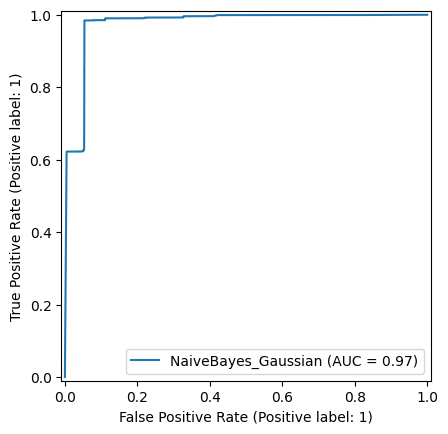

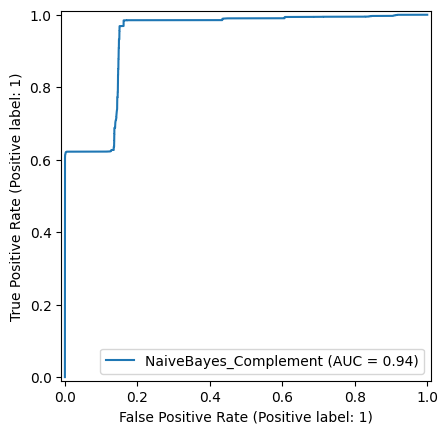

In [8]:
# Cell 7: Naive Bayes
# Try GaussianNB first (works with continuous features)
nb_model = GaussianNB()
nb_model.fit(X_train_sel, y_train)
joblib.dump(nb_model, "models/naive_bayes_gaussian.joblib")
metrics_nb = evaluate_and_plot(nb_model, X_test_sel, y_test, "NaiveBayes_Gaussian")

# Optional: ComplementNB if you expect sparse/positive counts (convert to non-negative)
try:
    from sklearn.preprocessing import MinMaxScaler
    # map features to [0,1] (already scaled) and use ComplementNB
    cnb = ComplementNB()
    cnb.fit(X_train_sel.clip(min=0), y_train)
    joblib.dump(cnb, "models/naive_bayes_complement.joblib")
    metrics_cnb = evaluate_and_plot(cnb, X_test_sel.clip(min=0), y_test, "NaiveBayes_Complement")
except Exception as e:
    print("ComplementNB skipped (not applicable):", e)

# Tips for NB:
print("\nNB tips:\n - GaussianNB assumes features are Gaussian; if heavy tails exist consider log-transform.\n - ComplementNB or MultinomialNB are good for count-like features.\n - NB is very fast and good as baseline.")


### K-Nearest Neighbors (KNN)


=== Evaluation: KNN_default ===
              precision    recall  f1-score   support

           0     0.9985    0.9982    0.9984     82632
           1     0.9962    0.9969    0.9965     38989

    accuracy                         0.9978    121621
   macro avg     0.9974    0.9975    0.9975    121621
weighted avg     0.9978    0.9978    0.9978    121621

ROC AUC: 0.9994008977849407
Saved confusion matrix -> reports/KNN_default_confusion.png
ROC plot error: cannot unpack non-iterable RocCurveDisplay object
Saved PR curve -> reports/KNN_default_pr.png

KNN tips:
 - KNN scales poorly to large datasets; using KDTree/ball_tree or limiting features helps.
 - n_neighbors and weights are important; use distance weighting for imbalanced data.


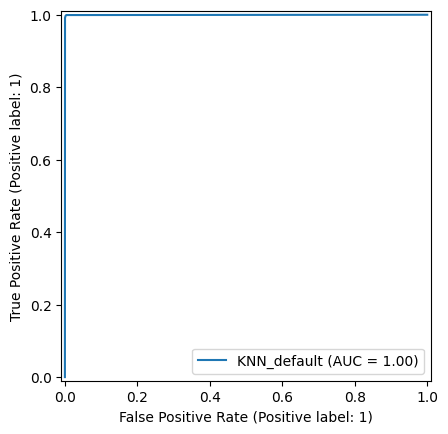

In [9]:
# Cell 8: KNN
knn = KNeighborsClassifier()
# quick fit with defaults
knn.fit(X_train_sel, y_train)
joblib.dump(knn, "models/knn_default.joblib")
metrics_knn = evaluate_and_plot(knn, X_test_sel, y_test, "KNN_default")

# Optional: GridSearch (uncomment to run, can be slow)
"""
param_grid_knn = {
    'n_neighbors': [3,5,7,9],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski']  # 'euclidean' is special case of minkowski
}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=3, scoring='f1', n_jobs=-1)
grid_knn.fit(X_train_sel, y_train)
print("KNN best params:", grid_knn.best_params_)
best_knn = grid_knn.best_estimator_
joblib.dump(best_knn, "models/knn_grid.joblib")
metrics_knn = evaluate_and_plot(best_knn, X_test_sel, y_test, "KNN_grid")
"""
print("\nKNN tips:\n - KNN scales poorly to large datasets; using KDTree/ball_tree or limiting features helps.\n - n_neighbors and weights are important; use distance weighting for imbalanced data.")


### Support Vector Machine (SVM)


=== Evaluation: SVM_RBF ===
              precision    recall  f1-score   support

           0     0.9973    0.9656    0.9812     82632
           1     0.9316    0.9944    0.9620     38989

    accuracy                         0.9748    121621
   macro avg     0.9645    0.9800    0.9716    121621
weighted avg     0.9762    0.9748    0.9750    121621

ROC AUC: 0.9992500663573296
Saved confusion matrix -> reports/SVM_RBF_confusion.png
ROC plot error: cannot unpack non-iterable RocCurveDisplay object
Saved PR curve -> reports/SVM_RBF_pr.png

SVM tips:
 - Use class_weight='balanced' for imbalanced sets.
 - RBF kernel captures non-linear patterns but is slow; for larger data consider linear SVM or approximate kernels.
 - Tune C and gamma with grid search. Standardize or scale features (you already scaled).


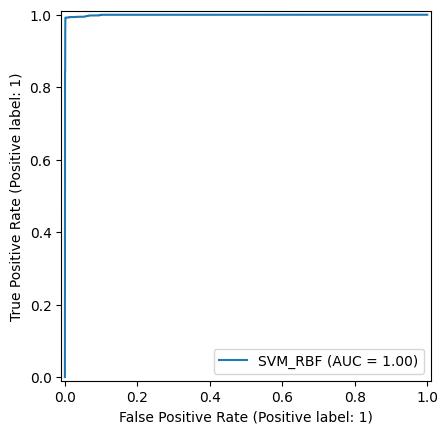

In [10]:
# Cell 9: SVM (RBF kernel) with probability enabled (costly)
svm = SVC(kernel='rbf', class_weight='balanced', random_state=RANDOM_STATE)
svm.fit(X_train_sel, y_train)
joblib.dump(svm, "models/svm_rbf.joblib")
metrics_svm = evaluate_and_plot(svm, X_test_sel, y_test, "SVM_RBF")

# Optional GridSearch parameters (uncomment to run)
"""
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf']
}
grid_svm = GridSearchCV(SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE),
                        param_grid_svm, scoring='f1', cv=3, n_jobs=-1)
grid_svm.fit(X_train_sel, y_train)
print('Best SVM params:', grid_svm.best_params_)
svm_best = grid_svm.best_estimator_
joblib.dump(svm_best, 'models/svm_grid.joblib')
metrics_svm = evaluate_and_plot(svm_best, X_test_sel, y_test, 'SVM_grid')
"""
print("\nSVM tips:\n - Use class_weight='balanced' for imbalanced sets.\n - RBF kernel captures non-linear patterns but is slow; for larger data consider linear SVM or approximate kernels.\n - Tune C and gamma with grid search. Standardize or scale features (you already scaled).")


### Gradient Boosting (GBDT)


=== Evaluation: GradientBoosting ===
              precision    recall  f1-score   support

           0     0.9971    0.9992    0.9982     82632
           1     0.9984    0.9938    0.9961     38989

    accuracy                         0.9975    121621
   macro avg     0.9977    0.9965    0.9971    121621
weighted avg     0.9975    0.9975    0.9975    121621

ROC AUC: 0.9999486247962563
Saved confusion matrix -> reports/GradientBoosting_confusion.png
ROC plot error: cannot unpack non-iterable RocCurveDisplay object
Saved PR curve -> reports/GradientBoosting_pr.png

GB tips:
 - Powerful for tabular data; tune n_estimators, learning_rate, max_depth.
 - Try HistGradientBoostingClassifier (sklearn) or LightGBM/XGBoost for large-scale performance.
 - Use early_stopping based on validation set to avoid overfitting.


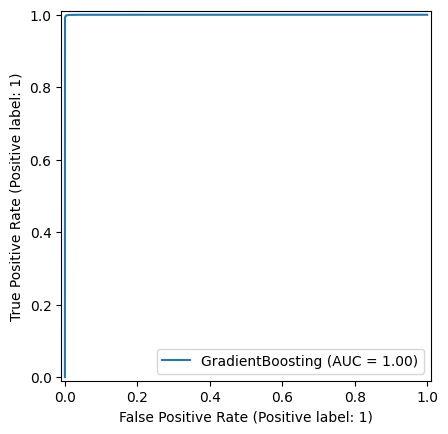

In [11]:
# Cell 10: GradientBoostingClassifier (sklearn)
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=RANDOM_STATE)
gb.fit(X_train_sel, y_train)
joblib.dump(gb, "models/gradient_boosting.joblib")
metrics_gb = evaluate_and_plot(gb, X_test_sel, y_test, "GradientBoosting")

# Optional grid (uncomment to run)
"""
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.05],
    'max_depth': [3, 5],
}
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE), param_grid_gb, scoring='f1', cv=3, n_jobs=-1)
grid_gb.fit(X_train_sel, y_train)
print('Best GB params:', grid_gb.best_params_)
best_gb = grid_gb.best_estimator_
joblib.dump(best_gb, 'models/gradient_boosting_grid.joblib')
metrics_gb = evaluate_and_plot(best_gb, X_test_sel, y_test, 'GradientBoosting_grid')
"""
print("\nGB tips:\n - Powerful for tabular data; tune n_estimators, learning_rate, max_depth.\n - Try HistGradientBoostingClassifier (sklearn) or LightGBM/XGBoost for large-scale performance.\n - Use early_stopping based on validation set to avoid overfitting.")


### AdaBoost


=== Evaluation: AdaBoost ===
              precision    recall  f1-score   support

           0     0.9940    0.9685    0.9811     82632
           1     0.9366    0.9877    0.9615     38989

    accuracy                         0.9746    121621
   macro avg     0.9653    0.9781    0.9713    121621
weighted avg     0.9756    0.9746    0.9748    121621

ROC AUC: 0.9968448540218333
Saved confusion matrix -> reports/AdaBoost_confusion.png
ROC plot error: cannot unpack non-iterable RocCurveDisplay object
Saved PR curve -> reports/AdaBoost_pr.png

AdaBoost tips:
 - Use DecisionStump (depth=1) or shallow trees as base estimators.
 - Learning rate and n_estimators trade off; tune them.
 - Sensitive to noisy labels/outliers; pruning or lower learning rate helps.


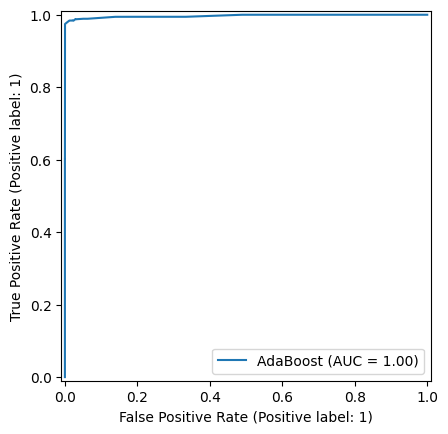

In [13]:
# Cell 11: AdaBoost with DecisionStump (max_depth=1)
base = DecisionTreeClassifier(max_depth=1, class_weight='balanced', random_state=RANDOM_STATE)
ada = AdaBoostClassifier(estimator=base, n_estimators=100, learning_rate=0.5, random_state=RANDOM_STATE)
ada.fit(X_train_sel, y_train)
joblib.dump(ada, "models/adaboost.joblib")
metrics_ada = evaluate_and_plot(ada, X_test_sel, y_test, "AdaBoost")

print("\nAdaBoost tips:\n - Use DecisionStump (depth=1) or shallow trees as base estimators.\n - Learning rate and n_estimators trade off; tune them.\n - Sensitive to noisy labels/outliers; pruning or lower learning rate helps.")


In [14]:
# Cell 12: Summary table of ROC AUC (and F1 from classification report)
import json
def extract_metrics(metrics):
    cr = metrics["classification_report"]
    # get f1 for class '1' (attack) if exists
    f1_attack = cr.get('1', {}).get('f1-score', None)
    return f1_attack, metrics.get('roc_auc', None)

models_metrics = {
    "NaiveBayes_Gaussian": metrics_nb,
    "KNN_default": metrics_knn,
    "SVM_RBF": metrics_svm,
    "GradientBoosting": metrics_gb,
    "AdaBoost": metrics_ada
}

summary_rows = []
for name, m in models_metrics.items():
    f1_attack, roc_auc = extract_metrics(m)
    summary_rows.append((name, f1_attack, roc_auc))

summary_df = pd.DataFrame(summary_rows, columns=['model','f1_attack','roc_auc']).sort_values(by='roc_auc', ascending=False)
display(summary_df)
summary_df.to_csv("reports/models_summary.csv", index=False)
print("Saved summary -> reports/models_summary.csv")


,model,f1_attack,roc_auc
3,GradientBoosting,0.996093,0.999949
1,KNN_default,0.996539,0.999401
2,SVM_RBF,0.962013,0.999250
4,AdaBoost,0.961487,0.996845
0,NaiveBayes_Gaussian,0.737466,0.974947


Saved summary -> reports/models_summary.csv
